# Comparison of Briere and flexTPC models in insect development data

In [1]:
import numpy as np
import pandas as pd
import random
random.seed(42) # Set seed for reproducibility

from matplotlib import pyplot as plt

from scipy.optimize import minimize
from sklearn.model_selection import LeaveOneOut

In [2]:
def briere1(T, Tmin=10.0, Tmax=50.0, c=1.0):
    result = np.zeros(len(T))
    cond = (Tmin < T) & (T < Tmax)
    result[cond] = c * T[cond] * np.exp(np.log(T[cond] - Tmin) + 0.5 * np.log(Tmax - T[cond]))
    return result

def briere2(T, Tmin=10.0, Tmax=50.0, c=1.0, b=2.0):
    result = np.zeros(len(T))
    cond = (Tmin < T) & (T < Tmax)
    result[cond] = c * T[cond] * np.exp(np.log(T[cond] - Tmin) +  np.log(Tmax - T[cond]) / b)
    return result

# Fully biologically interpretable parametrization of flexTPC model.
def flexTPC(T, Tmin=10.0, Tmax=50.0, rmax=1.0, α=0.8, β=0.2):
    result = np.zeros(len(T))
    cond = (Tmin < T) & (T < Tmax)
    s = α * (1.0 - α) / β**2
    result[cond] = rmax * np.exp(s * (α * (np.log(T[cond] - Tmin) - np.log(α)) +
                                      (1 - α) * (np.log(Tmax - T[cond]) - np.log(1 - α) )
                                       - np.log(Tmax - Tmin)))
    return result

# Exponential product curve.
def expprodcurve(T, Tmin=10.0, Tmax=50.0, c=1.0, kI=0.1, kU=0.5):
    result = np.zeros(len(T))
    cond = (Tmin < T) & (T < Tmax)
    result[cond] = c * (1.0 - np.exp(-kI*(T[cond] - Tmin))) * (1.0 - np.exp(-kU*(Tmax - T[cond])))
    return result

# Kumaraswarmy distribution TPC.
def kumaraswarmy(T, Tmin=10.0, Tmax=50.0, c=1.0, a=5.0, b=5.0):
    result = np.zeros(len(T))
    cond = (Tmin < T) & (T < Tmax)
    τ = (T[cond] - Tmin) / (Tmax - Tmin)
    result[cond] = c * τ**(a - 1) * (1.0 - τ**a)**(b - 1)
    return result

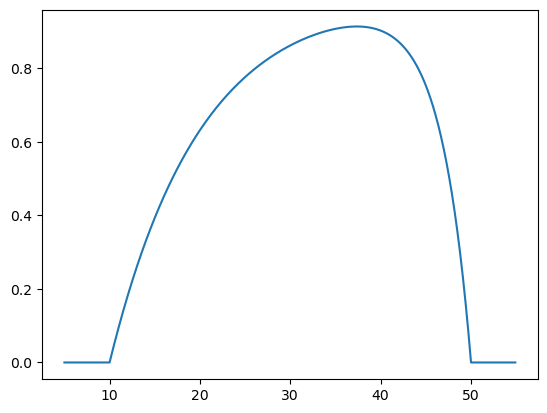

In [3]:
Tvals = np.arange(5, 55, 0.1)
plt.plot(Tvals, expprodcurve(Tvals, kI=0.1, kU=0.3))

In [4]:
def nloglik(θ, Tdata, rdata, model=flexTPC):
    params, σ2 = θ[:-1], θ[-1]
    Tmin, Tmax = θ[:2]
    outside = (Tdata < Tmin) | (Tdata > Tmax)
    inside = ~outside
    n = len(rdata[inside])
    if np.any(rdata[outside] > 0.0):
        return np.inf
    else:
        return 0.5 * (n * np.log(2*np.pi*σ2) + np.sum((rdata[inside] - model(Tdata[inside], *params))**2 / σ2))
    
def AIC(nll, p):
    return 2 * nll + 2 * p 

def BIC(nll, n, p):
    return 2 * nll + p * np.log(n)

## L. botrana development dataset

First, let's compare the model performance in Briere's original dataset.

In [5]:
botrana = pd.read_csv("briere_data_L_botrana.csv")
stages = ["eggs", "i1", "i2", "i3", "i4", "i5", "pupae"]

In [6]:
botrana

,T,n_eggs,eggs,n_i1,i1,n_i2,i2,n_i3,i3,n_i4,i4,n_i5,i5,n_pupae,pupae
0,8,0,inf,0,inf,0,inf,0,inf,0,inf,0,inf,0,inf
1,10,0,inf,28,25.9,14,23.2,0,inf,0,inf,0,inf,0,inf
2,12,77,26.8,48,23.4,23,16.1,15,12.7,12,15.7,11,25.5,0,inf
3,14,104,19.4,45,15.1,36,10.6,32,9.8,31,10.6,31,17.9,6,48.0
4,16,369,15.6,47,13.2,41,8.9,36,8.3,35,10.0,33,13.5,25,35.5
5,18,600,11.0,44,11.7,41,7.1,40,5.6,38,7.0,36,13.3,41,23.2
6,20,674,8.2,44,5.9,44,4.8,40,4.7,37,5.1,35,7.6,41,15.1
7,22,837,7.0,50,4.2,48,3.8,46,4.0,42,4.9,41,7.1,45,12.9
8,24,662,5.3,49,3.9,45,3.1,44,3.8,44,3.7,40,6.5,50,10.2
9,26,696,5.1,50,3.7,45,3.0,45,3.2,44,3.6,40,6.2,50,8.6


In [7]:
# Find initial estimates of minimum and maximum temperatures from data.
Tlims = {}
for i, stage in enumerate(stages):
    T = botrana["T"][botrana[stage] < np.inf]
    Tlims[stage] = (min(T) - 0.5, max(T) + 0.5)
    print(stage, Tlims[stage])

# Set initial estimates of maximum trait value.
init_rmax = {'eggs': 0.2,
             'i1':0.2,
             'i2':0.2,
             'i3':0.2,
             'i4':0.2,
             'i5':0.2,
            'pupae':0.2}

# Set initial parameter values for all models.
initial_flex = {stage:[7.0, 36.0, init_rmax[stage], 0.8, 0.1, 0.015] for stage in stages}
initial_b1 = {stage:[7.0, 36.0, 7e-5, 0.015] for stage in stages}
initial_b2 = {stage:[7.0, 36.0, 7e-5, 2.0, 0.015] for stage in stages}
initial_epc = {stage:[7.0, 36.0, init_rmax[stage], 0.1, 0.3, 0.015] for stage in stages}
initial_kum = {stage:[7.0, 36.0, 0.5, 3, 2, 0.015] for stage in stages}

eggs (11.5, 30.5)
i1 (9.5, 34.5)
i2 (9.5, 34.5)
i3 (11.5, 32.5)
i4 (11.5, 32.5)
i5 (11.5, 32.5)
pupae (13.5, 32.5)


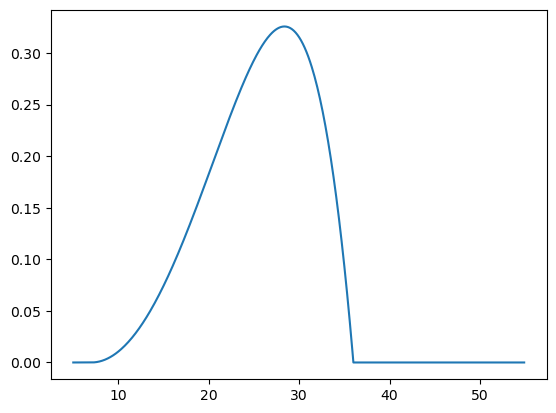

In [8]:
Tvals = np.arange(5, 55, 0.1)
plt.plot(Tvals, kumaraswarmy(Tvals, Tmin=7.0, Tmax=36.0, c=1.0, a=3, b=2))

In [9]:
loo = LeaveOneOut()
loo.get_n_splits(botrana["T"])

14

In [10]:
# Calculate leave-one-out cross validated log likelihood.
params = {"flexTPC":{}, "b1":{}, "b2":{}, "epc":{}, "kum":{}}
models = ["b1", "b2", "flexTPC", "epc", "kum"]
method = "Nelder-Mead"
loocv_nll = {model:{stage:[] for stage in stages } for model in models}

for i, y in enumerate(stages):
    Tdata = np.array(botrana["T"])
    rdata = 1.0 / np.array(botrana[y])
    
    for train, test in loo.split(Tdata):
        T_train, r_train = Tdata[train], rdata[train]
        T_test, r_test = Tdata[test], rdata[test]
        
        params["b1"][y] = minimize(nloglik, initial_b1[y],
                            bounds=[(0.0, 20.0), 
                                    (20.0, 60.0), 
                                    (0.0, 1.0),  
                                    (0, 1.0)],
                      args=(T_train, r_train, briere1), options={"maxiter":100000}, method=method)
        θ = params["b1"][y]["x"]
        loocv_nll["b1"][y].append(nloglik(θ, T_test, r_test, model=briere1))
        
        params["b2"][y] = minimize(nloglik, initial_b2[y],
                            bounds=[(0.0, 20.0), 
                                    (20.0, 60.0), 
                                    (0.0, 1.0), 
                                    (1.0, 20.0),
                                    (0, 1.0)],
                      args=(Tdata, rdata, briere2), options={"maxiter":100000}, method=method)
        θ = params["b2"][y]["x"]
        loocv_nll["b2"][y].append(nloglik(θ, T_test, r_test, model=briere2))
        
        params["flexTPC"][y] = minimize(nloglik, initial_flex[y],
                                bounds=[(0.0, 20.0), 
                                        (20.0, 60.0), 
                                        (0.0, 1.0), 
                                        (0.0, 1.0), 
                                        (0.0, np.inf), 
                                        (0, 1.0)],
                          args=(Tdata, rdata, flexTPC), options={"maxiter":100000}, method=method)
        θ = params["flexTPC"][y]["x"]
        loocv_nll["flexTPC"][y].append(nloglik(θ, T_test, r_test, model=flexTPC))

        params["epc"][y] = minimize(nloglik, initial_epc[y],
                                bounds=[(0.0, 20.0), 
                                        (20.0, 60.0), 
                                        (0.0, 1.0), 
                                        (0.0, np.inf), 
                                        (0.0, np.inf), 
                                        (0, 1.0)],
                          args=(Tdata, rdata, expprodcurve), options={"maxiter":100000}, method=method)
        θ = params["epc"][y]["x"]
        loocv_nll["epc"][y].append(nloglik(θ, T_test, r_test, model=expprodcurve))

        params["kum"][y] = minimize(nloglik, initial_kum[y],
                                bounds=[(0.0, 20.0), 
                                        (20.0, 60.0), 
                                        (0.0, np.inf), 
                                        (1.0, np.inf), 
                                        (1.0, np.inf), 
                                        (0, 1.0)],
                          args=(Tdata, rdata, kumaraswarmy), options={"maxiter":100000}, method=method)
        θ = params["kum"][y]["x"]
        loocv_nll["kum"][y].append(nloglik(θ, T_test, r_test, model=kumaraswarmy))

/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_90008/2868019315.py:10: RuntimeWarning: divide by zero encountered in log
  return 0.5 * (n * np.log(2*np.pi*σ2) + np.sum((rdata[inside] - model(Tdata[inside], *params))**2 / σ2))
/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_90008/2868019315.py:10: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (n * np.log(2*np.pi*σ2) + np.sum((rdata[inside] - model(Tdata[inside], *params))**2 / σ2))
/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_90008/2868019315.py:10: RuntimeWarning: invalid value encountered in scalar add
  return 0.5 * (n * np.log(2*np.pi*σ2) + np.sum((rdata[inside] - model(Tdata[inside], *params))**2 / σ2))


In [11]:
# Fit to entire dataset.

params = {"flexTPC":{}, "b1":{}, "b2":{}, "epc":{}, "kum":{}}
models = ["b1", "b2", "flexTPC", "epc", "kum"]
method = "Nelder-Mead"

for i, y in enumerate(stages):
    Tdata = np.array(botrana["T"])
    rdata = 1.0 / np.array(botrana[y])
    
    
    params["b1"][y] = minimize(nloglik, initial_b1[y],
                        bounds=[(0.0, 20.0), 
                                (20.0, 60.0), 
                                (0.0, 1.0),  
                                (0, 1.0)],
                  args=(Tdata, rdata, briere1), options={"maxiter":100000}, method=method)
    params["b2"][y] = minimize(nloglik, initial_b2[y],
                        bounds=[(0.0, 20.0), 
                                (20.0, 60.0), 
                                (0.0, 1.0), 
                                (1.0, 20.0),
                                (0, 1.0)],
                  args=(Tdata, rdata, briere2), options={"maxiter":100000}, method=method)
    params["flexTPC"][y] = minimize(nloglik, initial_flex[y],
                        bounds=[(0.0, 20.0), 
                                (20.0, 60.0), 
                                (0.0, 1.0), 
                                (0.0, 1.0), 
                                (0.0, np.inf), 
                                (0, 1.0)],
                  args=(Tdata, rdata, flexTPC), options={"maxiter":100000}, method=method)
    params["epc"][y] = minimize(nloglik, initial_epc[y],
                                bounds=[(0.0, 20.0), 
                                        (20.0, 60.0), 
                                        (0.0, 1.0), 
                                        (0.0, np.inf), 
                                        (0.0, np.inf), 
                                        (0, 1.0)],
                          args=(Tdata, rdata, expprodcurve), options={"maxiter":100000}, method=method)
    params["kum"][y] = minimize(nloglik, initial_kum[y],
                                bounds=[(0.0, 20.0), 
                                        (20.0, 60.0), 
                                        (0.0, np.inf), 
                                        (1.0, np.inf), 
                                        (1.0, np.inf), 
                                        (0, 1.0)],
                          args=(Tdata, rdata, kumaraswarmy), options={"maxiter":100000}, method=method)


/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_90008/2868019315.py:10: RuntimeWarning: divide by zero encountered in log
  return 0.5 * (n * np.log(2*np.pi*σ2) + np.sum((rdata[inside] - model(Tdata[inside], *params))**2 / σ2))
/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_90008/2868019315.py:10: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (n * np.log(2*np.pi*σ2) + np.sum((rdata[inside] - model(Tdata[inside], *params))**2 / σ2))
/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_90008/2868019315.py:10: RuntimeWarning: invalid value encountered in scalar add
  return 0.5 * (n * np.log(2*np.pi*σ2) + np.sum((rdata[inside] - model(Tdata[inside], *params))**2 / σ2))


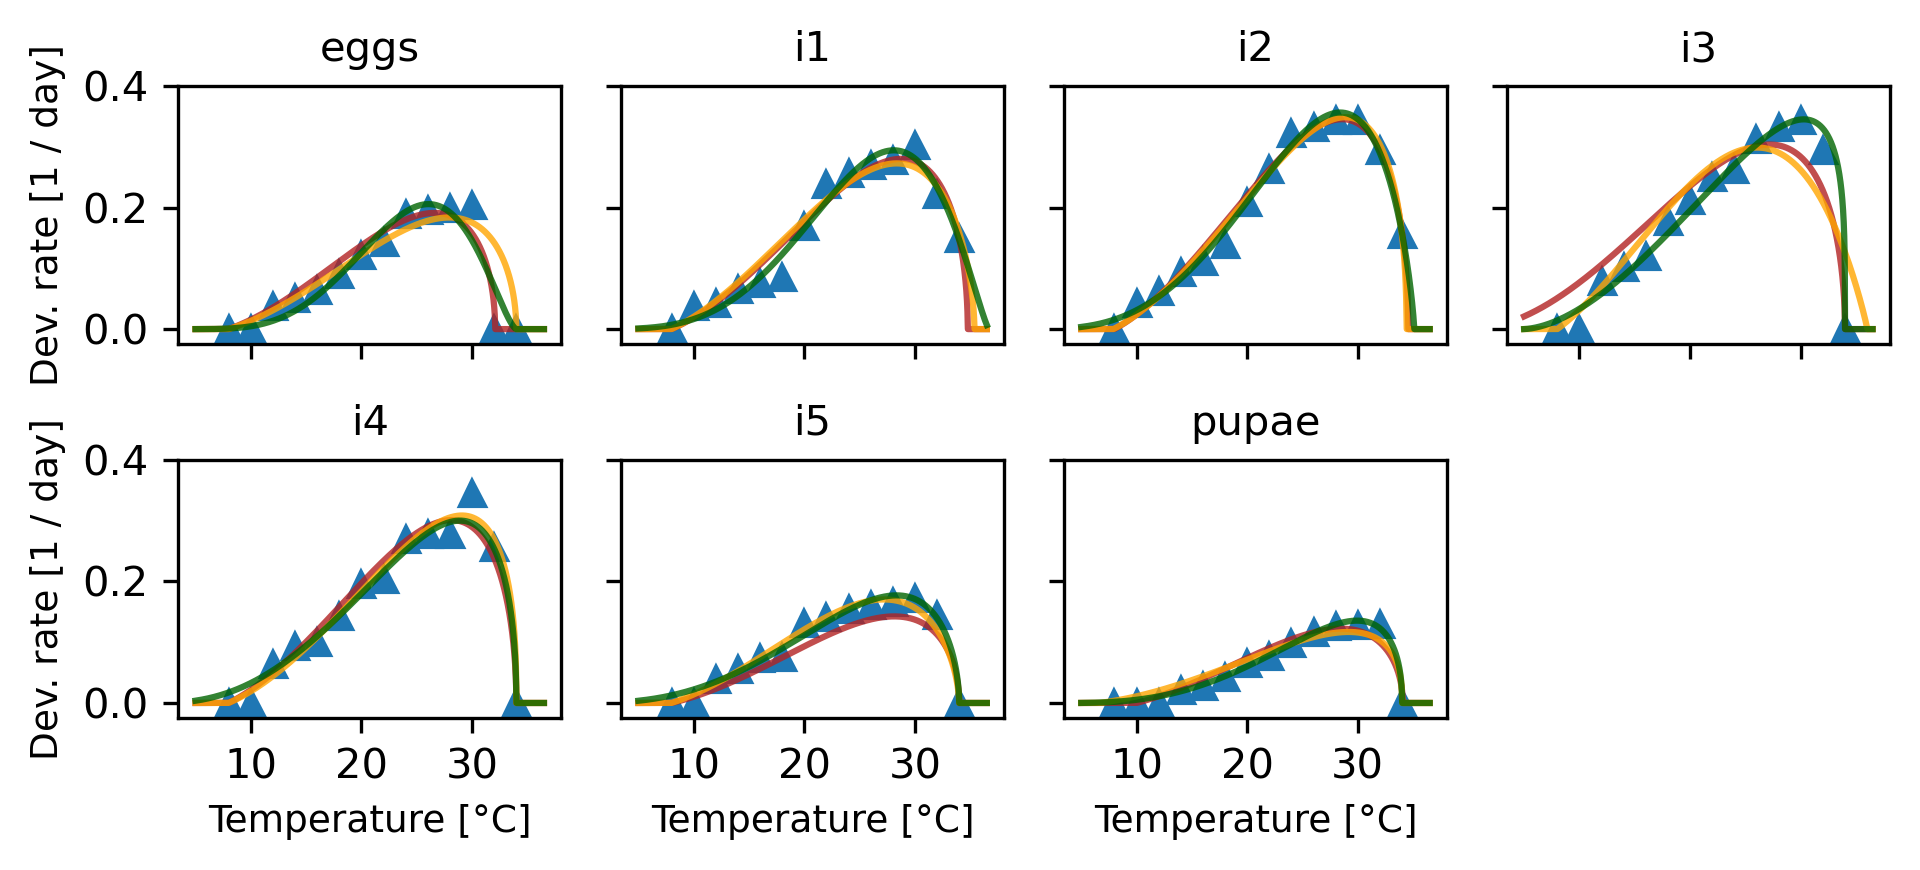

In [12]:
T = np.arange(5, 36.5, 0.001)
#plt.figure(figsize=(5, 6.5), dpi=300)
#plt.figure(figsize=(4.33, 6.5), dpi=300)
alpha=0.8

fig, axarr = plt.subplots(2, 4, figsize=(6.5, 3), dpi=300, sharex=True, sharey=True)

for i, y in enumerate(stages):
    ax = axarr[i // 4, i % 4]
    Tdata = np.array(botrana["T"])
    rdata = 1.0 / np.array(botrana[y])

    ax.plot(Tdata, rdata, '^')
    
    # Plot fitted curves by models.
    par = params["b1"][y]["x"]
    ax.plot(T, briere1(T, *par[:-1]), color="firebrick", alpha=alpha)
             
    par = params["b2"][y]["x"]
    ax.plot(T, briere2(T, *par[:-1]), color="orange", alpha=alpha)
    
    par = params["flexTPC"][y]["x"]
    ax.plot(T, flexTPC(T, *par[:-1]), color="darkgreen", alpha=alpha)

    #par = params["epc"][y]["x"]
    #ax.plot(T, expprodcurve(T, *par[:-1]), color="purple", alpha=alpha)

    #par = params["kum"][y]["x"]
    #ax.plot(T, kumaraswarmy(T, *par[:-1]), color="blue", alpha=alpha)
    
    ax.set_ylim(-0.025, 0.4)
    if y in ("eggs", "i4"):
        ax.set_ylabel("Dev. rate [1 / day]", fontsize=9)
    if y in ("i4", "i5", "pupae"):
        ax.set_xlabel("Temperature [°C]", fontsize=9)
    ax.set_title(y, fontsize=10)
axarr[-1, -1].axis("off")
plt.tight_layout()
plt.savefig("botrana.svg")
plt.savefig("botrana.tiff")
plt.savefig("botrana.png")
plt.savefig("botrana.pdf")

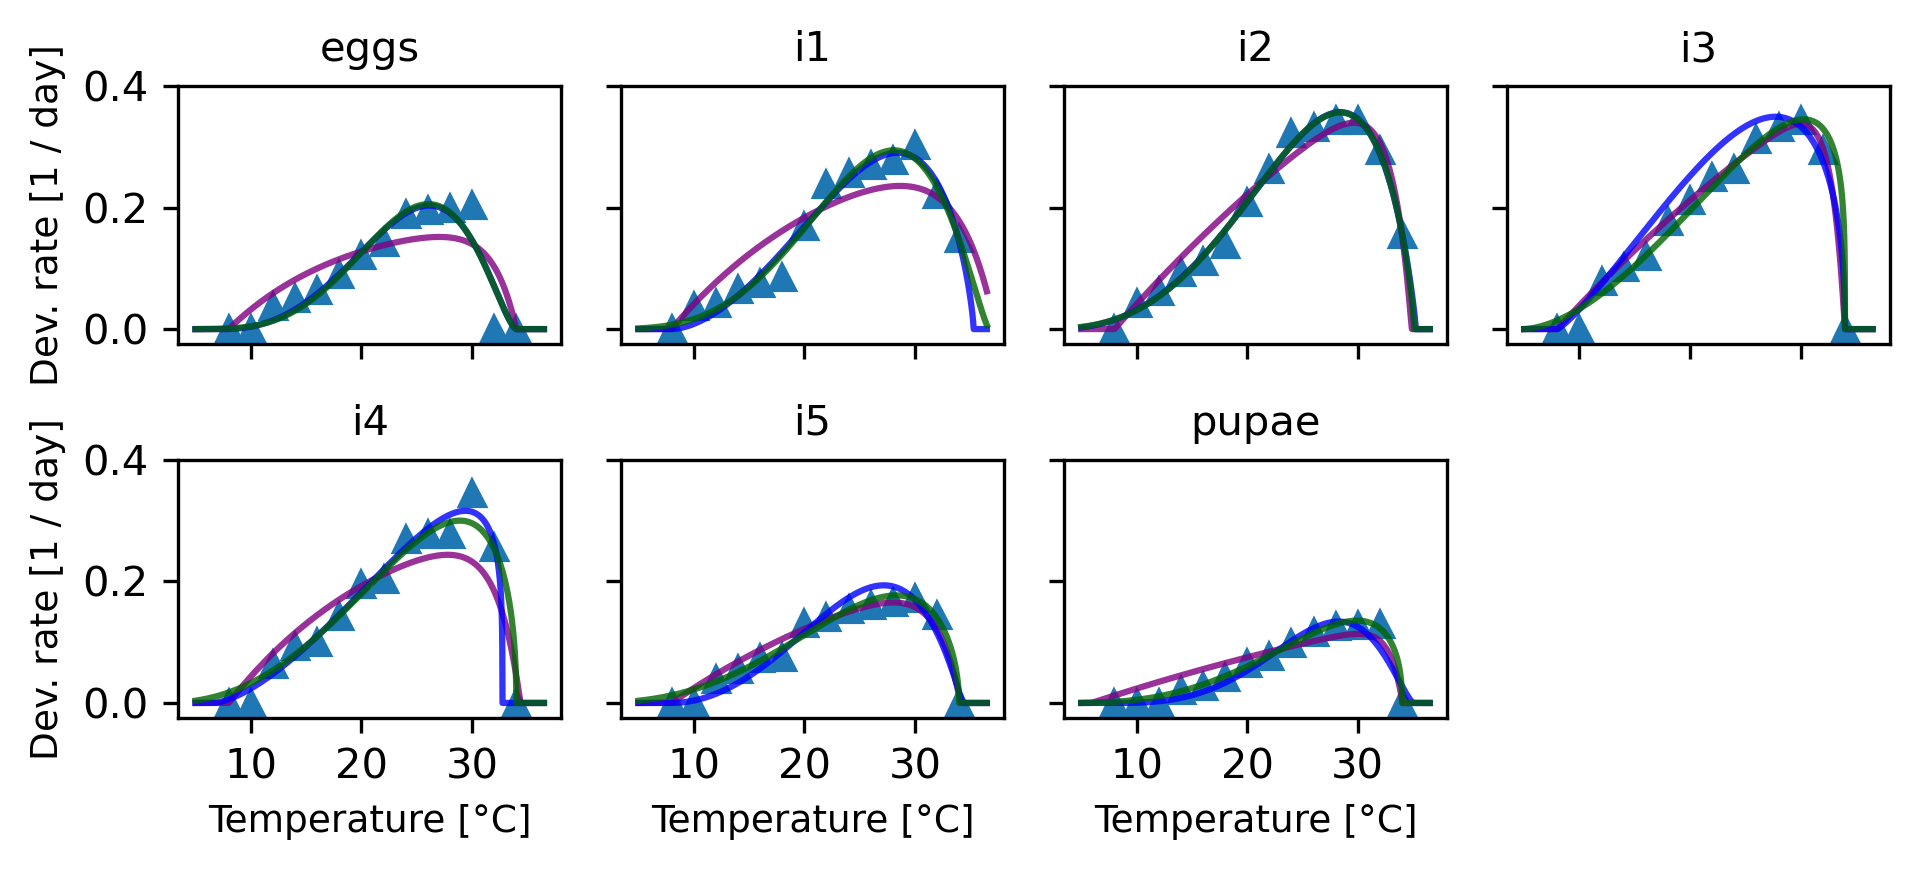

In [13]:
T = np.arange(5, 36.5, 0.001)
#plt.figure(figsize=(5, 6.5), dpi=300)
#plt.figure(figsize=(4.33, 6.5), dpi=300)
alpha=0.8

fig, axarr = plt.subplots(2, 4, figsize=(6.5, 3), dpi=300, sharex=True, sharey=True)

for i, y in enumerate(stages):
    ax = axarr[i // 4, i % 4]
    Tdata = np.array(botrana["T"])
    rdata = 1.0 / np.array(botrana[y])

    ax.plot(Tdata, rdata, '^')
    
    # Plot fitted curves by models.
    #par = params["b1"][y]["x"]
    #ax.plot(T, briere1(T, *par[:-1]), color="firebrick", alpha=alpha)
             
    #par = params["b2"][y]["x"]
    #ax.plot(T, briere2(T, *par[:-1]), color="orange", alpha=alpha)
    
    

    par = params["epc"][y]["x"]
    ax.plot(T, expprodcurve(T, *par[:-1]), color="purple", alpha=alpha)

    par = params["kum"][y]["x"]
    ax.plot(T, kumaraswarmy(T, *par[:-1]), color="blue", alpha=alpha)

    par = params["flexTPC"][y]["x"]
    ax.plot(T, flexTPC(T, *par[:-1]), color="darkgreen", alpha=alpha)
    
    ax.set_ylim(-0.025, 0.4)
    if y in ("eggs", "i4"):
        ax.set_ylabel("Dev. rate [1 / day]", fontsize=9)
    if y in ("i4", "i5", "pupae"):
        ax.set_xlabel("Temperature [°C]", fontsize=9)
    ax.set_title(y, fontsize=10)
axarr[-1, -1].axis("off")
plt.tight_layout()
plt.savefig("botrana_pc_kum.svg")
plt.savefig("botrana_pc_kum.pdf")

In [14]:
n_params = {'b1':4, 'b2':5, 'flexTPC':6, 'epc':6, 'kum':6} # Includes standard deviation.
param_matrix = {model:np.zeros((7, n_params[model])) for model in models}

for model in models:
    for i, stage in enumerate(stages):
        param_matrix[model][i, ] = params[model][stage]["x"]

colnames = {'b1':['Tmin', 'Tmax', 'c', 'sigma2'],
            'b2':['Tmin', 'Tmax', 'c', 'm', 'sigma2'],
            'flexTPC':['Tmin', 'Tmax', 'rmax', 'alpha', 'beta', 'sigma2'],
            'epc':['Tmin', 'Tmax', 'c', 'kI', 'kU', 'sigma2'],
            'kum':['Tmin', 'Tmax', 'c', 'a', 'b', 'sigma2']}

param_df = {model:pd.DataFrame(param_matrix[model], columns=colnames[model]) for model in models}
for model in models:
    param_df[model]['stage'] = stages
    param_df[model] = param_df[model][['stage'] + colnames[model]]
    param_df[model].to_csv(f'botrana_params_{model}.csv', index=False)

In [15]:
np.round(param_df['flexTPC'], 3)

,stage,Tmin,Tmax,rmax,alpha,beta,sigma2
0,eggs,4.026,34.000,0.206,0.735,0.185,0.001
1,i1,0.000,36.692,0.294,0.765,0.181,0.000
2,i2,0.003,35.100,0.356,0.809,0.194,0.000
3,i3,4.870,34.000,0.345,0.872,0.235,0.000
4,i4,1.618,34.000,0.300,0.842,0.212,0.000
5,i5,0.000,34.000,0.177,0.833,0.205,0.000
6,pupae,3.476,34.000,0.135,0.867,0.186,0.000


In [16]:
np.round(param_df['epc'], 3)

,stage,Tmin,Tmax,c,kI,kU,sigma2
0,eggs,8.000,34.000,0.191,0.093,0.463,0.002
1,i1,8.000,37.293,0.356,0.061,0.301,0.002
2,i2,8.000,34.878,1.000,0.021,0.521,0.001
3,i3,8.000,34.000,0.987,0.020,0.776,0.000
4,i4,8.000,34.375,0.353,0.066,0.451,0.002
5,i5,8.000,34.129,0.337,0.038,0.433,0.000
6,pupae,5.926,34.055,0.341,0.018,0.810,0.000


In [17]:
np.round(param_matrix['flexTPC'], 3)

array([[4.0260e+00, 3.4000e+01, 2.0600e-01, 7.3500e-01, 1.8500e-01,
        1.0000e-03],
       [0.0000e+00, 3.6692e+01, 2.9400e-01, 7.6500e-01, 1.8100e-01,
        0.0000e+00],
       [3.0000e-03, 3.5100e+01, 3.5600e-01, 8.0900e-01, 1.9400e-01,
        0.0000e+00],
       [4.8700e+00, 3.4000e+01, 3.4500e-01, 8.7200e-01, 2.3500e-01,
        0.0000e+00],
       [1.6180e+00, 3.4000e+01, 3.0000e-01, 8.4200e-01, 2.1200e-01,
        0.0000e+00],
       [0.0000e+00, 3.4000e+01, 1.7700e-01, 8.3300e-01, 2.0500e-01,
        0.0000e+00],
       [3.4760e+00, 3.4000e+01, 1.3500e-01, 8.6700e-01, 1.8600e-01,
        0.0000e+00]])

In [18]:
stage

'pupae'

In [30]:
nll = np.zeros((len(stages), len(models)))
loo_nll = np.zeros((len(stages), len(models)))
aic = np.zeros((len(stages), len(models)))
bic = np.zeros((len(stages), len(models)))


p = [4, 5, 6, 6, 6] # Number of parameters (including variance parameter).
n = 14 # Number of datapoints.

for i, s in enumerate(stages):
    for j, m in enumerate(models): 
        nll[i, j] = params[m][s]["fun"]
        loo_nll[i, j] = np.mean(loocv_nll[m][s])
        aic[i, j] = AIC(nll[i, j], p[j])
        bic[i, j] = BIC(nll[i, j], n, p[j])

In [46]:
dfAIC = pd.DataFrame(np.round(aic, 2), columns=models, index=stages)
dfBIC = pd.DataFrame(np.round(bic, 2), columns=models, index=stages)
dfLOOCV = pd.DataFrame(np.round(loo_nll, 2), columns=models, index=stages)

In [47]:
dfAIC

,b1,b2,flexTPC,epc,kum
eggs,-55.89,-40.25,-49.61,-36.70,-49.90
i1,-59.19,-54.92,-62.00,-36.96,-59.09
i2,-71.53,-70.63,-74.22,-53.56,-74.17
i3,-41.38,-33.46,-60.92,-67.59,-23.05
i4,-59.92,-63.21,-58.29,-34.20,-56.36
i5,-57.53,-75.16,-75.49,-66.79,-59.69
pupae,-68.13,-72.66,-98.48,-58.19,-66.32


In [48]:
dfBIC

,b1,b2,flexTPC,epc,kum
eggs,-53.33,-37.06,-45.78,-32.86,-46.07
i1,-56.64,-51.73,-58.17,-33.12,-55.26
i2,-68.98,-67.44,-70.39,-49.73,-70.34
i3,-38.82,-30.26,-57.09,-63.75,-19.21
i4,-57.36,-60.02,-54.45,-30.37,-52.53
i5,-54.97,-71.97,-71.66,-62.96,-55.86
pupae,-65.58,-69.46,-94.65,-54.36,-62.49


In [45]:
dfLOOCV

,b1,b2,flexTPC,epc,kum
eggs,1.997,-1.795,-2.200,-1.739,-2.211
i1,-1.464,-2.319,-2.643,-1.748,-2.539
i2,-2.238,-2.880,-3.079,-2.342,-3.078
i3,7.161,-1.552,-2.604,-2.842,-1.252
i4,2.135,-2.615,-2.510,-1.650,-2.442
i5,-0.475,-3.041,-3.125,-2.814,-2.561
pupae,10.803,-2.952,-3.946,-2.507,-2.797


In [35]:
def get_delta(df):
    '''
    Turns results into difference relative to best model.
    '''
    best = np.min(df, axis=1) 
    return(df.subtract(np.min(df, axis=1), axis=0))

In [36]:
dfAIC

,b1,b2,flexTPC,epc,kum
eggs,-55.89,-40.25,-49.61,-36.70,-49.90
i1,-59.19,-54.92,-62.00,-36.96,-59.09
i2,-71.53,-70.63,-74.22,-53.56,-74.17
i3,-41.38,-33.46,-60.92,-67.59,-23.05
i4,-59.92,-63.21,-58.29,-34.20,-56.36
i5,-57.53,-75.16,-75.49,-66.79,-59.69
pupae,-68.13,-72.66,-98.48,-58.19,-66.32


In [37]:
get_delta(dfAIC)

,b1,b2,flexTPC,epc,kum
eggs,0.00,15.64,6.28,19.19,5.99
i1,2.81,7.08,0.00,25.04,2.91
i2,2.69,3.59,0.00,20.66,0.05
i3,26.21,34.13,6.67,0.00,44.54
i4,3.29,0.00,4.92,29.01,6.85
i5,17.96,0.33,0.00,8.70,15.80
pupae,30.35,25.82,0.00,40.29,32.16


In [38]:
get_delta(dfBIC)

,b1,b2,flexTPC,epc,kum
eggs,0.00,16.27,7.55,20.47,7.26
i1,1.53,6.44,0.00,25.05,2.91
i2,1.41,2.95,0.00,20.66,0.05
i3,24.93,33.49,6.66,0.00,44.54
i4,2.66,0.00,5.57,29.65,7.49
i5,17.00,0.00,0.31,9.01,16.11
pupae,29.07,25.19,0.00,40.29,32.16


In [39]:
get_delta(dfLOOCV)

,b1,b2,flexTPC,epc,kum
eggs,4.21,0.42,0.01,0.47,0.00
i1,1.18,0.32,0.00,0.89,0.10
i2,0.84,0.20,0.00,0.74,0.00
i3,10.00,1.29,0.24,0.00,1.59
i4,4.75,0.00,0.10,0.96,0.17
i5,2.64,0.08,0.00,0.31,0.56
pupae,14.75,1.00,0.00,1.44,1.15


In [40]:
get_delta(dfLOOCV[['b1', 'b2', 'flexTPC']])

,b1,b2,flexTPC
eggs,4.20,0.41,0.0
i1,1.18,0.32,0.0
i2,0.84,0.20,0.0
i3,9.76,1.05,0.0
i4,4.75,0.00,0.1
i5,2.64,0.08,0.0
pupae,14.75,1.00,0.0


In [41]:
pd.DataFrame({'LOOCV':np.mean(get_delta(dfLOOCV), axis=0)})

,LOOCV
b1,5.481429
b2,0.472857
flexTPC,0.050000
epc,0.687143
kum,0.510000


In [23]:
print(dfLOOCV.to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & b1 & b2 & flexTPC & epc & kum \\
\midrule
eggs & 27.960000 & -25.130000 & -30.810000 & -24.350000 & -30.950000 \\
i1 & -20.500000 & -32.460000 & -37.000000 & -24.480000 & -35.540000 \\
i2 & -31.330000 & -40.320000 & -43.110000 & -32.780000 & -43.090000 \\
i3 & 100.250000 & -21.730000 & -36.460000 & -39.790000 & -17.520000 \\
i4 & 29.900000 & -36.610000 & -35.140000 & -23.100000 & -34.180000 \\
i5 & -6.650000 & -42.580000 & -43.750000 & -39.400000 & -35.850000 \\
pupae & 151.250000 & -41.330000 & -55.240000 & -35.100000 & -39.160000 \\
\bottomrule
\end{tabular}



In [24]:
print(dfAIC.to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & b1 & b2 & flexTPC & epc & kum \\
\midrule
eggs & -55.890000 & -40.250000 & -49.610000 & -36.700000 & -49.900000 \\
i1 & -59.190000 & -54.920000 & -62.000000 & -36.960000 & -59.090000 \\
i2 & -71.530000 & -70.630000 & -74.220000 & -53.560000 & -74.170000 \\
i3 & -41.380000 & -33.460000 & -60.920000 & -67.590000 & -23.050000 \\
i4 & -59.920000 & -63.210000 & -58.290000 & -34.200000 & -56.360000 \\
i5 & -57.530000 & -75.160000 & -75.490000 & -66.790000 & -59.690000 \\
pupae & -68.130000 & -72.660000 & -98.480000 & -58.190000 & -66.320000 \\
\bottomrule
\end{tabular}



In [25]:
print(dfBIC.to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & b1 & b2 & flexTPC & epc & kum \\
\midrule
eggs & -53.330000 & -37.060000 & -45.780000 & -32.860000 & -46.070000 \\
i1 & -56.640000 & -51.730000 & -58.170000 & -33.120000 & -55.260000 \\
i2 & -68.980000 & -67.440000 & -70.390000 & -49.730000 & -70.340000 \\
i3 & -38.820000 & -30.260000 & -57.090000 & -63.750000 & -19.210000 \\
i4 & -57.360000 & -60.020000 & -54.450000 & -30.370000 & -52.530000 \\
i5 & -54.970000 & -71.970000 & -71.660000 & -62.960000 & -55.860000 \\
pupae & -65.580000 & -69.460000 & -94.650000 & -54.360000 & -62.490000 \\
\bottomrule
\end{tabular}

